# Perform Cleaning

In [1]:
import pandas as pd
from db_utils import DataTransform
from db_utils import DataFrameInfo as dfinfo

%reload_ext autoreload
%autoreload 2

df = pd.read_csv('cust_act1.csv')
dtype_change = {
    "visitor_type": "category",
    "traffic_type": "category",
    "region": "category",
    "browser": "category",
    "operating_systems": "category",
    "administrative": "Int32",
    "informational": "Int32",
    "product_related": "Int32"
}
# Perform special transform case for months to be an ordered category
months_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month'] = pd.Categorical(df['month'], categories=months_ordered, ordered=True)
# Perform the transform from dict
df = DataTransform(df).changetype(dtype_change)

# Impute & drop rows
from db_utils import DataFrameTransform as dft

cols_to_impute_na = [
    "product_related_duration",
    "informational_duration",
    "administrative_duration"
]
cols_to_drop_na = [
    "operating_systems"
]
cols_to_mode_na = [
    "administrative",
    "product_related"
]

dft(df, cols_to_drop_na).drop_missing()
dft(df, cols_to_impute_na).impute_missing()
dft(df, cols_to_mode_na).impute_missing(strategy="mode")

# Copy DF with outliers removed

cols_with_outliers = [
    "administrative_duration",
    "informational_duration",
    "product_related_duration",
    "page_values"
]
df_sans_outliers = dft(df, columns=cols_with_outliers).drop_outliers(z_threshold=4.5)

# Manually drop overly correlated column
if "bounce_rates" in df_sans_outliers.columns:
    df_sans_outliers = df_sans_outliers.drop(columns="bounce_rates")

Successfully changed 'visitor_type' to category
Successfully changed 'traffic_type' to category
Successfully changed 'region' to category
Successfully changed 'browser' to category
Successfully changed 'operating_systems' to category
Successfully changed 'administrative' to Int32
Successfully changed 'informational' to Int32
Successfully changed 'product_related' to Int32
Dropped 11 rows with missing values in ['operating_systems'].
Before imputation: 201 nulls in 'product_related_duration'
After imputation: 0 nulls in 'product_related_duration'
Imputed missing values in 'product_related_duration' with median (586.00, skew=3.64).
Before imputation: 336 nulls in 'informational_duration'
After imputation: 0 nulls in 'informational_duration'
Imputed missing values in 'informational_duration' with median (0.00, skew=7.21).
Before imputation: 912 nulls in 'administrative_duration'
After imputation: 0 nulls in 'administrative_duration'
Imputed missing values in 'administrative_duration' with

In [2]:
dfcl = df_sans_outliers

dfcl.info()
dfcl.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 11844 entries, 0 to 12329
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   administrative            11844 non-null  Int32   
 1   administrative_duration   11844 non-null  float64 
 2   informational             11844 non-null  Int32   
 3   informational_duration    11844 non-null  float64 
 4   product_related           11844 non-null  Int32   
 5   product_related_duration  11844 non-null  float64 
 6   exit_rates                11844 non-null  float64 
 7   page_values               11844 non-null  float64 
 8   month                     11844 non-null  category
 9   operating_systems         11844 non-null  category
 10  browser                   11844 non-null  category
 11  region                    11844 non-null  category
 12  traffic_type              11844 non-null  category
 13  visitor_type              11844 non-null  category


,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,exit_rates,page_values,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0,0.0,0,0.0,4,0.0,0.200,0.0,May,Android,Google Chrome,North America,Twitter,Returning_Visitor,False,False
1,0,0.0,0,0.0,26,876.0,0.026,0.0,Nov,Windows,Google Chrome,Western Europe,Google search,Returning_Visitor,True,False
2,2,99.4,0,0.0,19,368.0,0.052,0.0,Sep,Windows,Google Chrome,Asia,Twitter,Returning_Visitor,False,False
3,0,0.0,0,0.0,20,1432.0,0.028,1.8,Dec,Windows,Google Chrome,Western Europe,Instagram ads,Returning_Visitor,False,True
4,0,0.0,0,0.0,33,694.0,0.032,0.0,May,Android,Google Chrome,North America,Instagram ads,Returning_Visitor,False,False
5,1,63.0,0,0.0,29,579.0,0.023,0.0,Mar,MACOS,Safari,North America,Google search,Returning_Visitor,False,False
6,3,87.0,0,0.0,11,1400.0,0.022,0.0,Mar,Android,Google Chrome,Western Europe,Google search,New_Visitor,True,False
7,0,0.0,0,0.0,1,1134.0,0.018,0.0,Dec,MACOS,Safari,North America,Youtube channel,New_Visitor,False,False
8,0,0.0,0,0.0,3,17.0,0.120,0.0,June,Windows,Microsoft Edge,North America,Instagram ads,Returning_Visitor,False,False
9,4,15.8,0,0.0,11,340.0,0.016,0.0,Aug,Windows,Microsoft Edge,South America,Instagram Page,New_Visitor,False,False


# What are our customers doing?

#### 1. Are sales proportionally happening more on weekends?
a: Yes! 15.8% of visits end in revenue on weekends and 14.3% on weekdays.

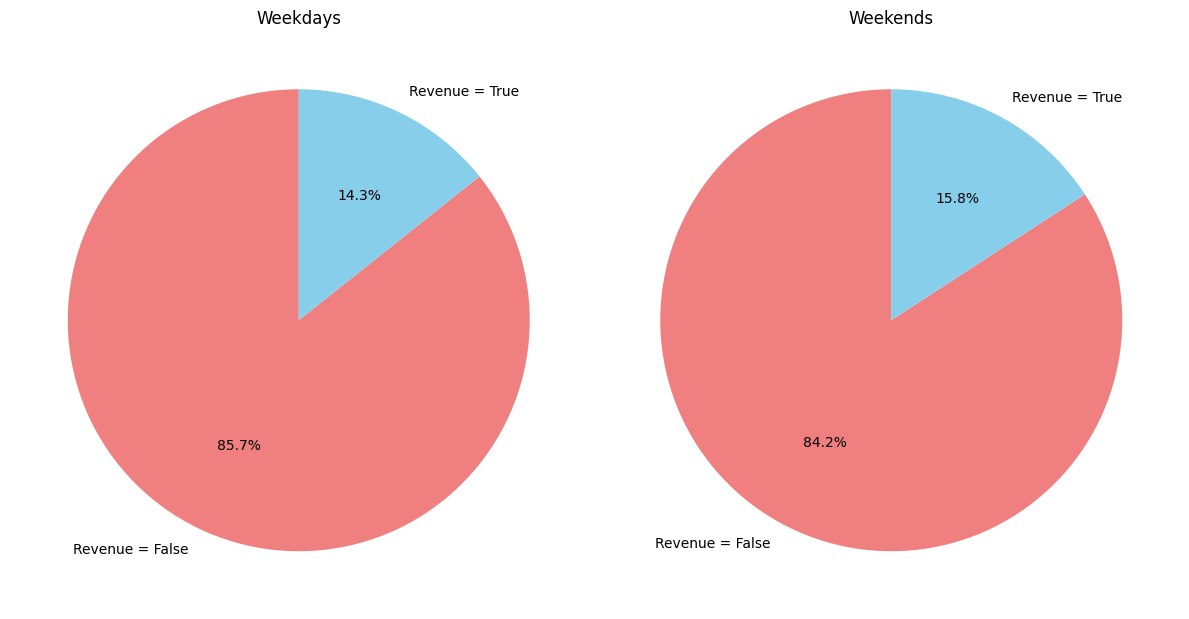

In [3]:
import matplotlib.pyplot as plt

counts = dfcl.groupby(["weekend", "revenue"]).size().unstack(fill_value=0)
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

weekday_counts = counts.loc[False]
axes[0].pie(
    weekday_counts, labels=["Revenue = False", "Revenue = True"], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue']
)
axes[0].set_title("Weekdays")

weekend_counts = counts.loc[True]
axes[1].pie(
    weekend_counts, labels=["Revenue = False", "Revenue = True"], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue']
)
axes[1].set_title("Weekends")

plt.tight_layout()
plt.show()

#### 2. Which regions are generating the most revenue currently?
a: North America

In [ ]:
import plotly.express as px

fig = px.histogram(
    dfcl,
    x="region",
    y="page_values",
    histfunc="sum",  
    color="region",
    title="Sum of Page Values by Region",
    labels={"page_values": "Sum of Page Values", "region": "Region"},
)
fig.update_layout(
    xaxis_title="Region",
    yaxis_title="Sum of Page Values",
    bargap=0.2,
    showlegend=False
)
fig.show()

#### 3. Is there any particular website traffic that stands out when generating sales?

In [ ]:
# Calculate the percentage of 'revenue = True' for each 'traffic_type'
percentage_revenue = (
    dfcl.groupby("traffic_type")["revenue"]
    .mean()  
    .reset_index(name="revenue_percentage")
)
# Convert to percentages
percentage_revenue["revenue_percentage"] *= 100

# Create the bar chart
fig = px.bar(
    percentage_revenue,
    x="traffic_type",
    y="revenue_percentage",
    title="Percentage of Revenue = True by Traffic Type",
    labels={"revenue_percentage": "Percentage of Revenue = True (%)", "traffic_type": "Traffic Type"},
    text="revenue_percentage",  
    color="traffic_type",  
)

# Customize the layout
fig.update_traces(texttemplate="%{text:.1f}%", textposition="outside")  # Format text as percentages
fig.update_layout(
    xaxis_title="Traffic Type",
    yaxis_title="Revenue = True (%)",
    yaxis_ticksuffix="%", 
    showlegend=False,
)

fig.show()

#### 4. What percentage of time is spent on the website performing administrative/product or informational related tasks?

In [ ]:
durations = [
    "administrative_duration",
    "informational_duration",
    "product_related_duration"
]
total_duration = dfcl[durations].sum(axis=1)


#### 5. Are there any informational/administrative tasks which users spend time doing most?

#### 6. What is the breakdown of months making the most sales?